In [12]:
#imports
import os, glob, json
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps

from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import selections
from enterprise.signals.selections import Selection

from enterprise_extensions import models, hypermodel
from enterprise_extensions.model_utils import bayes_fac
from la_forge import core as co
from la_forge import diagnostics as dg

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

# Make my pulsar objects

In [2]:
datadir = './20_pulsars/WN_only/'
parfiles = sorted(glob.glob(datadir+'Pars/*'))
timfiles = sorted(glob.glob(datadir+'Tims/*'))

psrs = []
for p, t in zip(parfiles,timfiles):
    psr = Pulsar(p,t)
    psrs.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


# Make signal model

In [96]:
selection = selections.Selection(selections.by_backend)

#WN parameters
efac = parameter.Uniform(0.0,10)
equad = parameter.Uniform(-18.5,2)
ecorr = parameter.Uniform(-8.5,-3)

#white noise
ef = white_signals.MeasurementNoise(efac=efac,log10_t2equad=equad, selection=selection)
#eq = white_signals.TNEquadNoise(log10_tnequad=equad,selection=selection)

#timing model
tm = gp_signals.TimingModel(use_svd=True)

#full model
s = tm + ef

my_ptas = [signal_base.PTA(s(psr)) for psr in psrs]


In [56]:
print(signal_base.PTA(s(psr)).param_names[0][:6])

JPSR19



# do sampling

In [98]:
my_pta = my_ptas[0]
main_output_dir = './chains/'
x0 = np.hstack([p.sample() for p in my_pta.params])
ndim = len(x0)

output_dir = main_output_dir + my_pta.param_names[0][:6]

os.makedirs(output_dir, exist_ok=True)

cov = np.diag(np.ones(ndim))

sampler = ptmcmc(ndim, my_pta.get_lnlikelihood, my_pta.get_lnprior, cov, outDir=output_dir, resume=False)

num_samps = int(10e4)
#sampler.sample(x0, num_samps,SCAMweight=30, AMweight=15, DEweight=50, )
sampler.sample(x0, num_samps)

Finished 1.00 percent in 0.177525 s Acceptance rate = 0.344

/home/mitch/miniconda3/envs/enterprise/lib/python3.12/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 1.730950 s Acceptance rate = 0.33438Adding DE jump with weight 20
Finished 100.00 percent in 16.041372 s Acceptance rate = 0.39183
Run Complete


In [89]:
main_output_dir = './chains/'
for my_pta in my_ptas:
    x0 = np.hstack([p.sample() for p in my_pta.params])
    ndim = len(x0)

    output_dir = main_output_dir + my_pta.param_names[0][:6]

    os.makedirs(output_dir, exist_ok=True)

    cov = np.diag(np.ones(ndim))

    sampler = ptmcmc(ndim, my_pta.get_lnlikelihood, my_pta.get_lnprior, cov, outDir=output_dir, resume=False)

    num_samps = int(10e4)
    #sampler.sample(x0, num_samps,SCAMweight=30, AMweight=15, DEweight=50, )
    sampler.sample(x0, num_samps)

Finished 10.00 percent in -0.375934 s Acceptance rate = 0.29546Adding DE jump with weight 20
Finished 100.00 percent in 13.564520 s Acceptance rate = 0.33242
Run Complete
Finished 10.00 percent in 1.581981 s Acceptance rate = 0.19568Adding DE jump with weight 20
Finished 100.00 percent in 15.253879 s Acceptance rate = 0.30013
Run Complete
Finished 10.00 percent in 1.629745 s Acceptance rate = 0.29544Adding DE jump with weight 20
Finished 100.00 percent in 13.118961 s Acceptance rate = 0.34287
Run Complete
Finished 10.00 percent in 1.693424 s Acceptance rate = 0.22737Adding DE jump with weight 20
Finished 100.00 percent in 16.029031 s Acceptance rate = 0.31451
Run Complete
Finished 10.00 percent in 1.665924 s Acceptance rate = 0.27644Adding DE jump with weight 20
Finished 100.00 percent in 13.061869 s Acceptance rate = 0.32428
Run Complete
Finished 10.00 percent in 1.586871 s Acceptance rate = 0.22164Adding DE jump with weight 20
Finished 100.00 percent in 15.370181 s Acceptance rate = 

# check chain

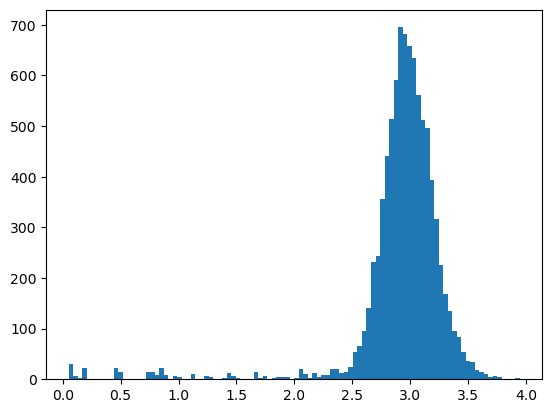

In [4]:
main_output_dir = './chains/'
chain = np.loadtxt(main_output_dir + 'JPSR00/chain_1.txt',delimiter='\t')
burn = int(0.1 * chain.shape[0])
n, bin, patches = plt.hist(chain[burn:,0],bins=100)

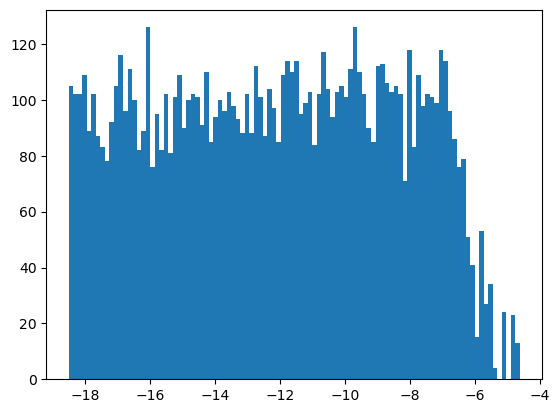

In [5]:
n, bin, patches =plt.hist(chain[burn:,1],bins=100)

# Plot with laforge

In [22]:
chains_dir = './chains/'
psr_files = []
psr_names = []
with open('Psr_names.txt','r') as file:
    for line in file:
        psr_names.append(line.strip())
        psr_files.append(chains_dir+line.strip())

core_arr = [co.Core(chaindir=(chains_dir+core),label=core,params=['efac','equad']) for core in psr_names]


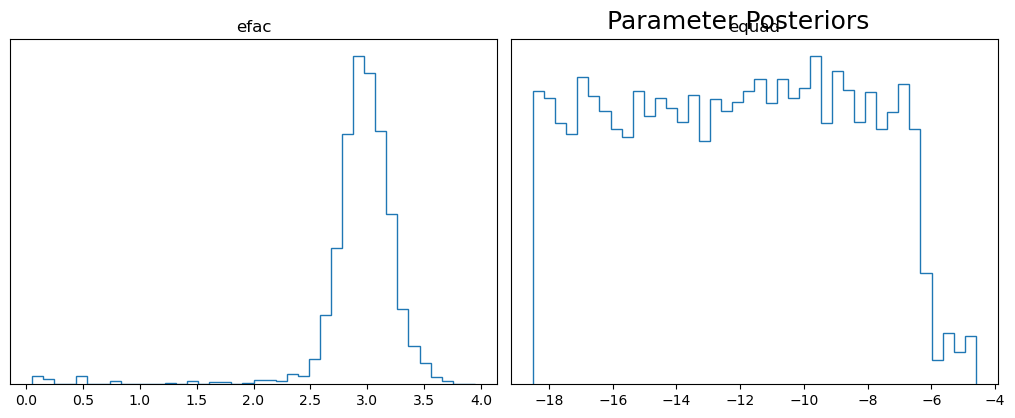

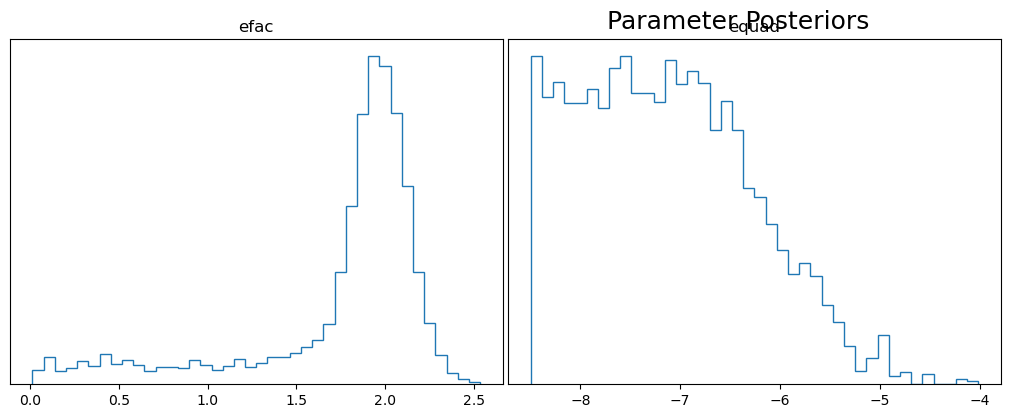

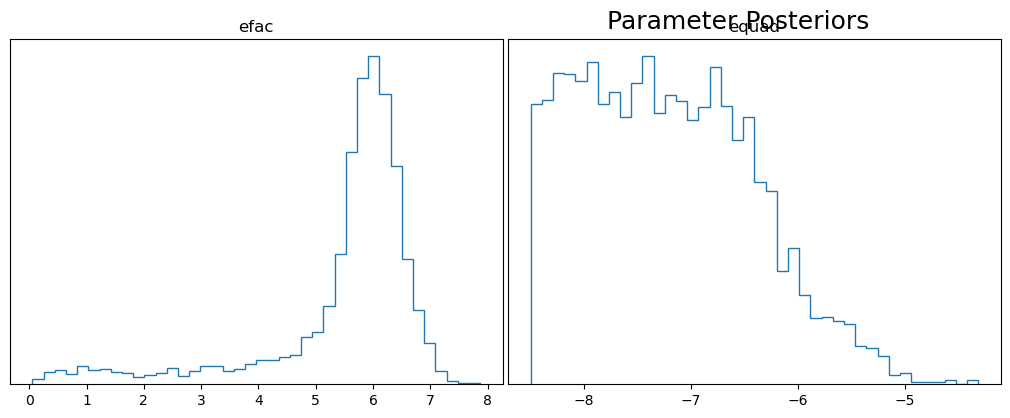

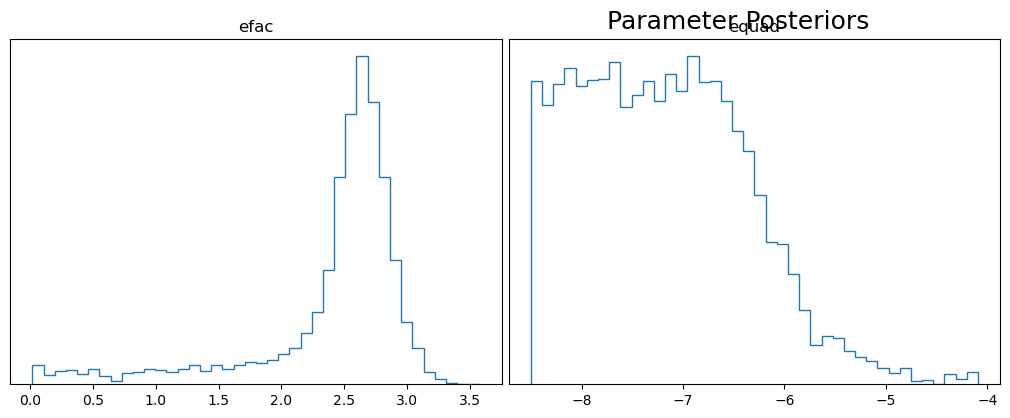

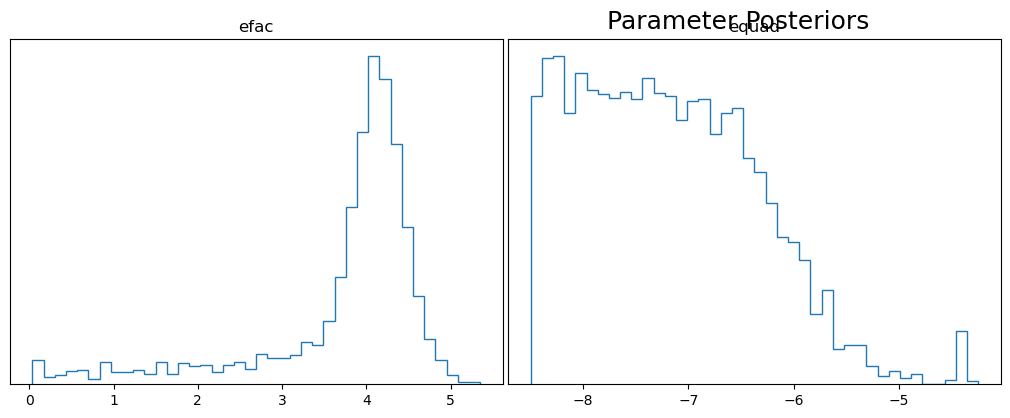

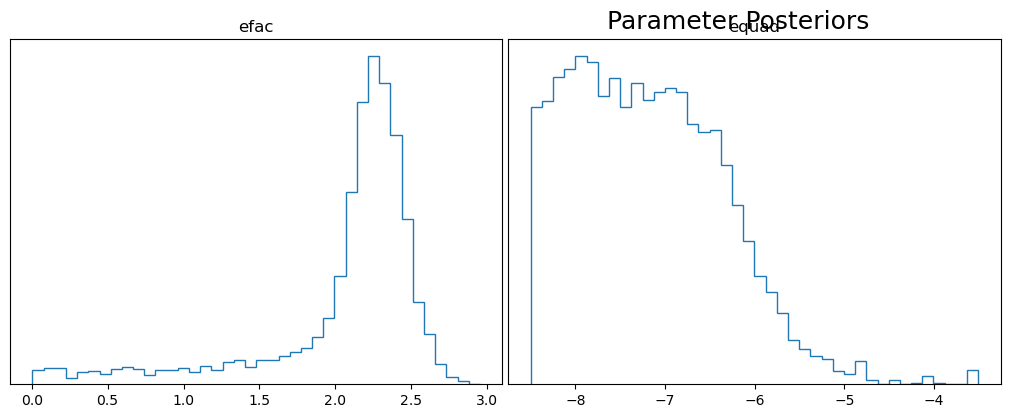

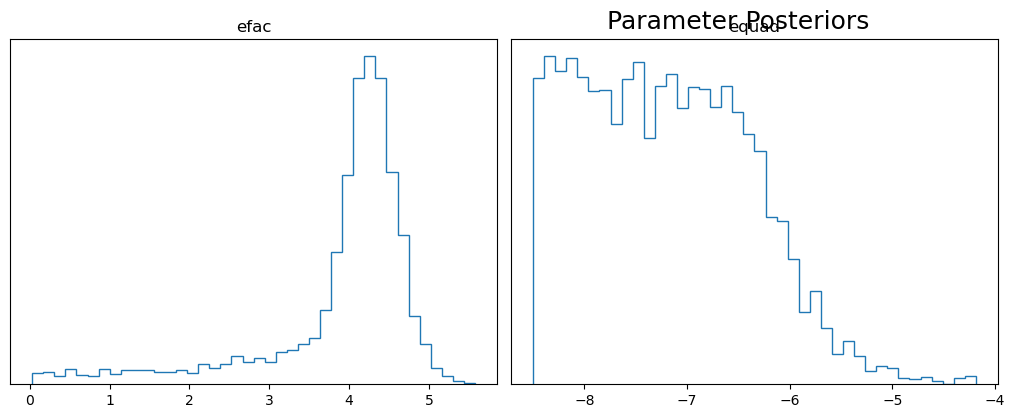

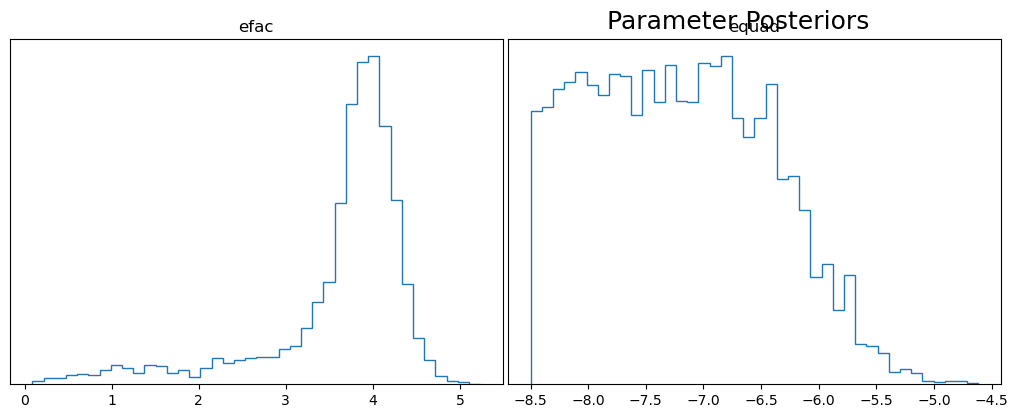

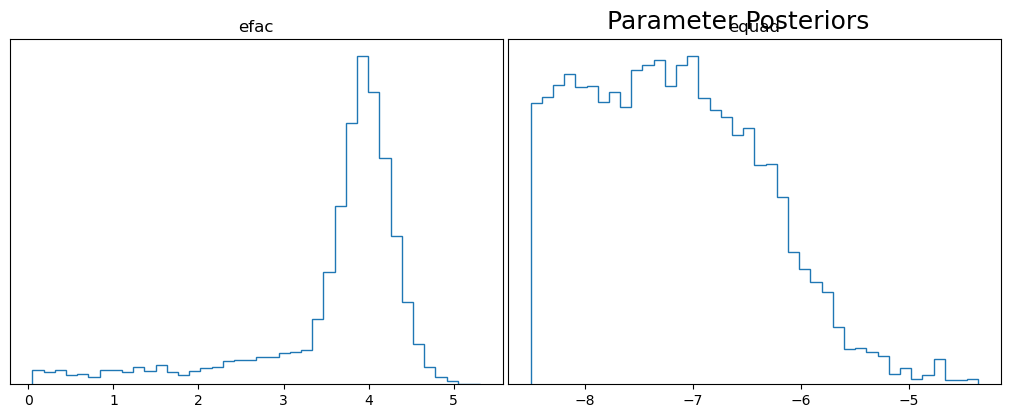

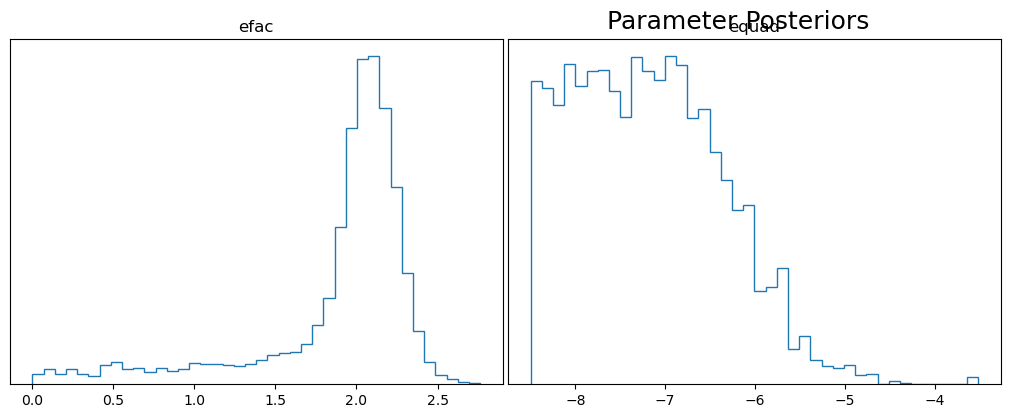

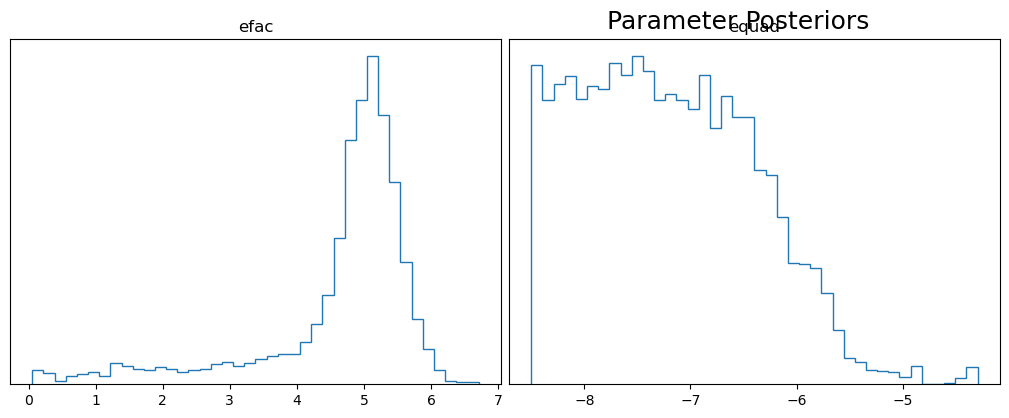

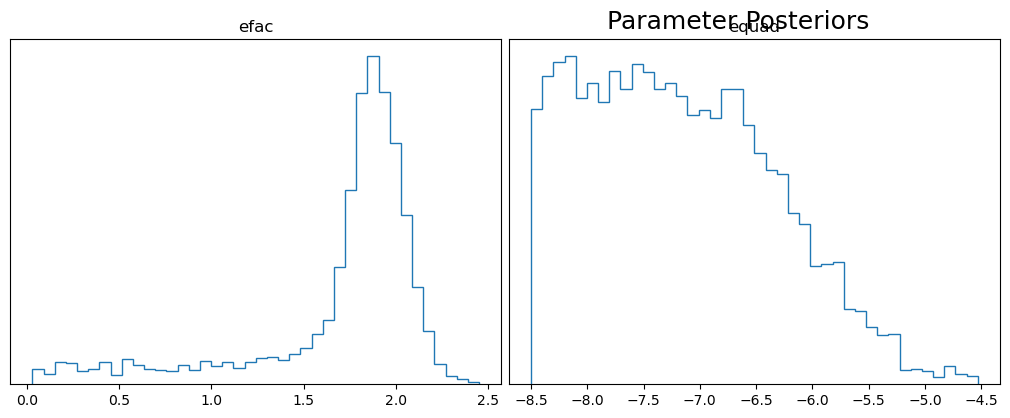

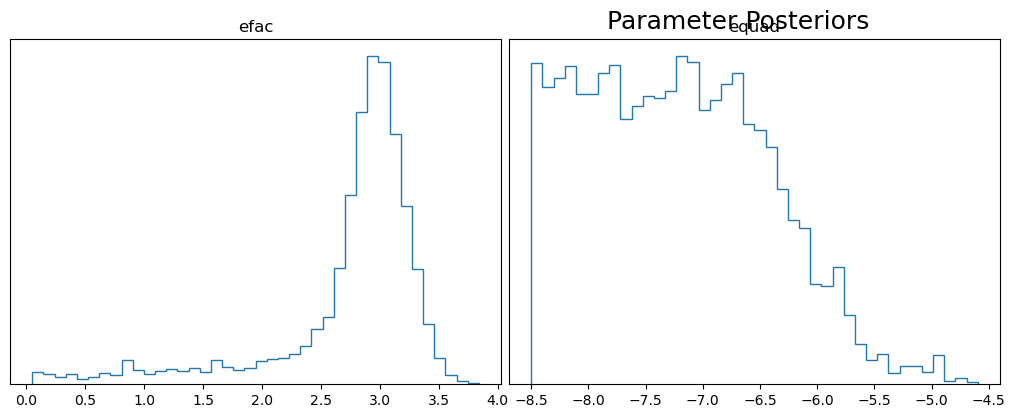

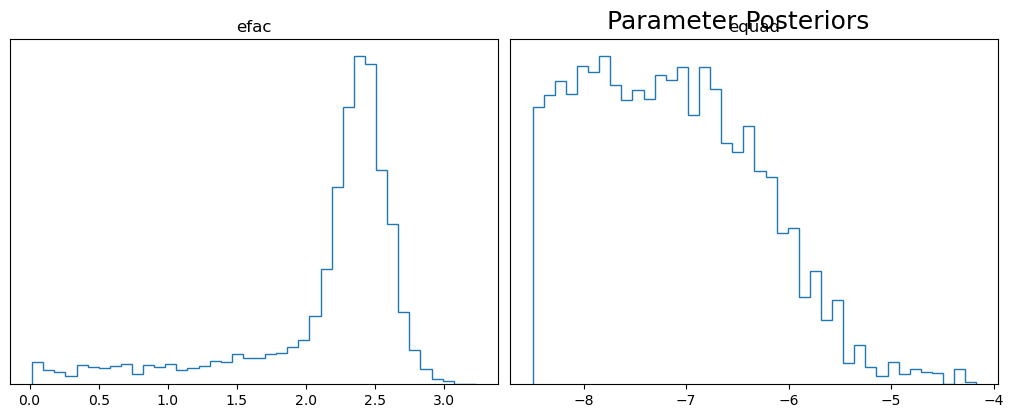

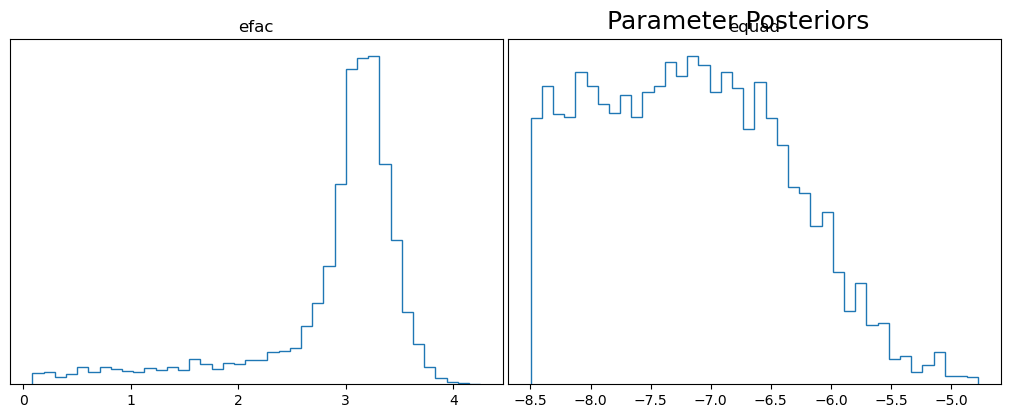

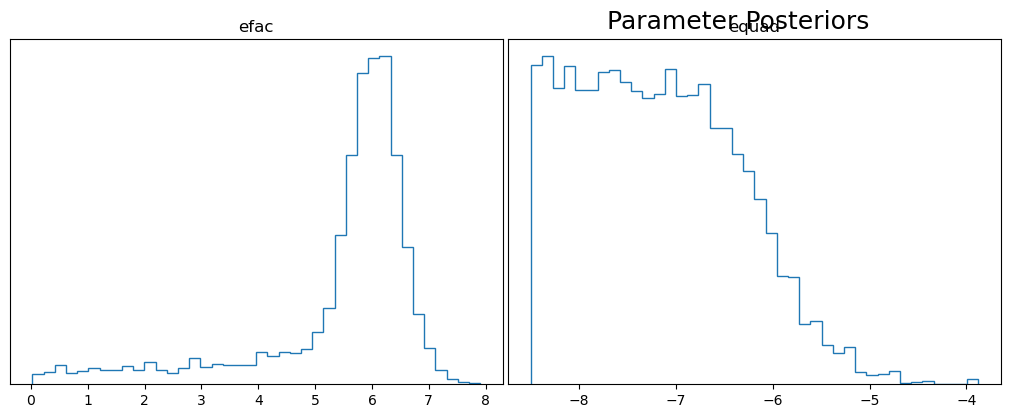

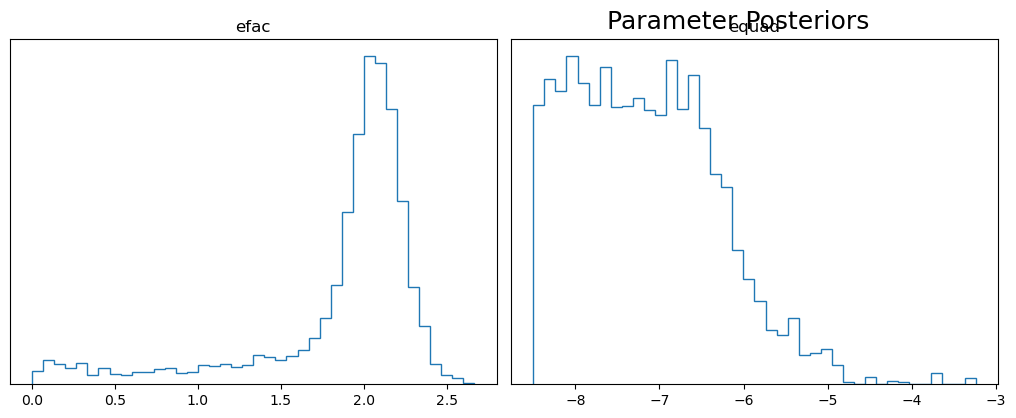

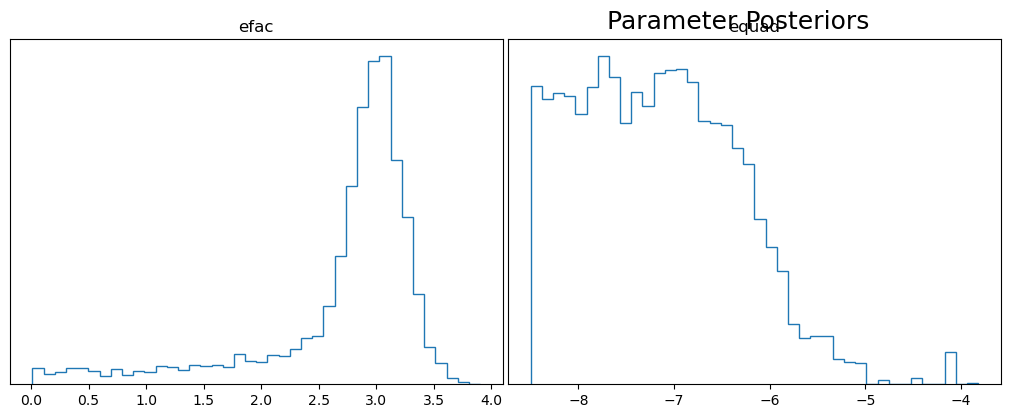

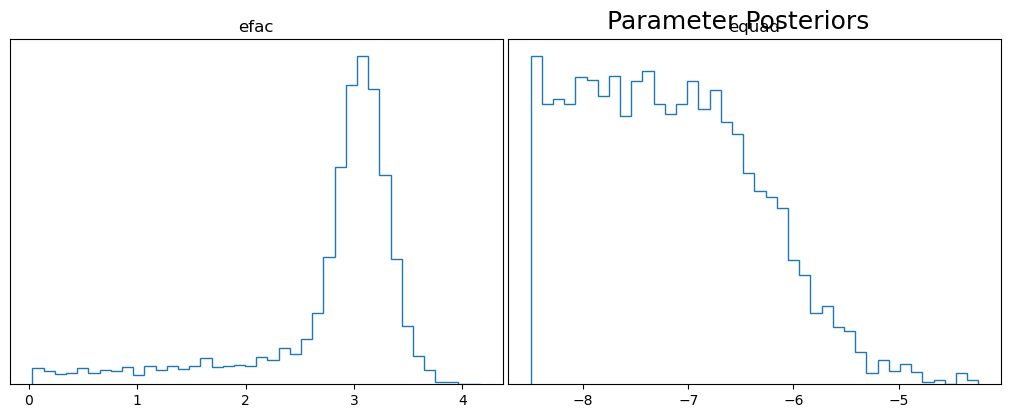

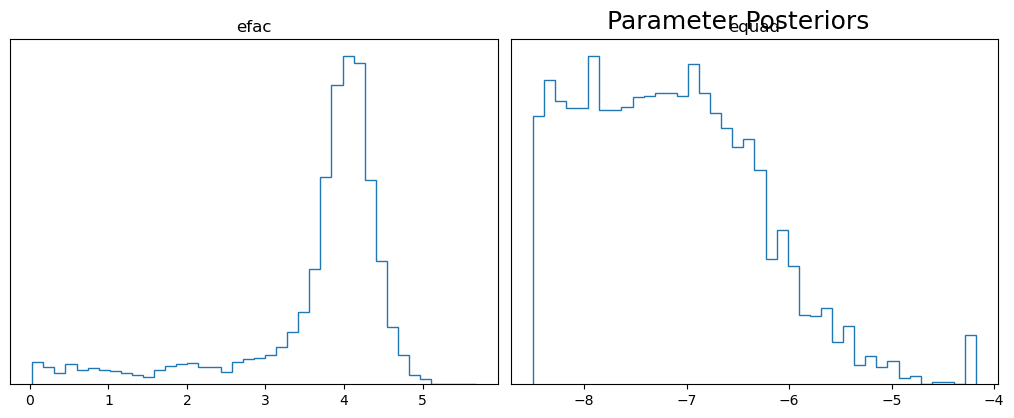

In [23]:
for core_file in core_arr:
    dg.plot_chains(core_file,pars=core_file.params[0:2])